# **PROBLEMA DE NEGOCIO**


---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

# **1. Configuración del Ambiente**


---

**Se importan las librerias necesarias para el análisis**
--

In [1]:
!pip install geobr
import geobr
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
from PIL import Image
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, Float, String, DateTime, inspect, text
global df_items_pedidos, df_pedidos, df_productos, df_vendedores, database

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.3
    Uninstalling shapely-2.0.3:
      Successfully uninstalled shapely-2.0.3
  Attempting uninstall: lxml
    Found existing installation: lxml 4.9.4
    Uninstalling lxml-4.9.4:
      Successfully uninstalled lxml-4.9.4
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2


# **2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---


## **2.1 Cargando las bases de datos**

Creamos una función para cargar todas las bases de datos necesarias para el análisis
--

In [14]:
def carga_datos():
  global df_items_pedidos, df_pedidos, df_productos, df_vendedores, database
  df_items_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
  df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
  df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
  df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')

## **2.2 Tratamiento de datos**

**Se visualiza la información general de cada dataframe previa al tratamiento**
--

In [15]:
carga_datos()
print(df_items_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 non-null  int64 
 2   vendedor_id   24527 non-null  int64 
 3   fecha_compra  24527 non-null  object
 

**Creamos una función para realizar preprocesamiento a todos los dataframes.**
--
*Se eliminan duplicados, se transforman datos numéricos a (int), textos a (str) y fechas a (datetime)*


In [16]:
#Preprocesamiento
def preprocesamiento(df_items_pedidos, df_pedidos, df_productos, df_vendedores):
    # Crear copias de los dataframes originales
    items_pedidos_copy = df_items_pedidos.copy()
    pedidos_copy = df_pedidos.copy()
    productos_copy = df_productos.copy()
    vendedores_copy = df_vendedores.copy()

    dataframes = [items_pedidos_copy, pedidos_copy, productos_copy, vendedores_copy]
    pedidos_copy['fecha_compra'] = pd.to_datetime(pedidos_copy['fecha_compra'])

    for df in dataframes:
        # Eliminar registros con valores nulos en las columnas clave
        df.dropna(subset=df.columns[df.columns.str.endswith('_id')], inplace=True)
        # Eliminar registros duplicados
        df.drop_duplicates(inplace=True)
        # Asegurar tipos de datos correctos
        for column in df.columns:
                if df[column].dtype == 'object':
                    df[column] = df[column].astype(str)
                elif df[column].dtype == 'float64':
                    df[column] = df[column].astype(float)
                elif df[column].dtype == 'int64':
                    df[column] = df[column].astype(int)
    return items_pedidos_copy, pedidos_copy, productos_copy, vendedores_copy


##Aplicar función de preprocesamiento y renombrando dataframes

In [17]:
items_pedidos_procesados, pedidos_procesados, productos_procesados, vendedores_procesados = preprocesamiento(df_items_pedidos, df_pedidos, df_productos, df_vendedores)

**Creamos una función para verificación.**
--
*Esta permite identificar inconsistencias en los datos como valores nulos, duplicados, caracteres especiales para columnas de texto y valores NaN en todo el data set.*


In [18]:
def verificacion(dataframe):
  global df_items_pedidos_procesados, df_pedidos_procesados, df_productos_procesados, df_vendedores_procesados, database
    # Verificar valores nulos
  print("Valores nulos por columna:")
  print(dataframe.isnull().sum())
  print("\n")

  # Verificar duplicados
  duplicados = dataframe.duplicated()
  df_duplicados = dataframe[duplicados]
  if not df_duplicados.empty:
      print("Filas duplicadas:")
      print(df_duplicados)
      print("\n")

  # Contar valores únicos en cada columna
  print("Conteo de valores únicos por columna:")
  for columna in dataframe.columns:
      print(f"Columna '{columna}': {dataframe[columna].nunique()} valores únicos")
      print(f"Valores únicos en '{columna}':")
      #print(dataframe[columna].unique())
      print("\n")

  # Verificar tipos de datos por columna
  print("\nTipos de datos por columna:")
  for columna in dataframe.columns:
      print(f"Columna '{columna}': {dataframe[columna].dtype}")

  # Verificar tipos de datos y buscar inconsistencias
  for columna in dataframe.select_dtypes(include=['object', 'string']).columns:
      print(f"\nVerificando inconsistencias en la columna '{columna}':")
      inconsistencias = dataframe[dataframe[columna].apply(lambda x: not all(ord(c) < 128 for c in str(x)))]
      if not inconsistencias.empty:
          print(inconsistencias)
          print("\n")

  #Verificar Nan en todo el dataset
  print("Valores NaN por columna:")
  df_nan = dataframe[dataframe.isna().any(axis=1)]
  print(df_nan.head())
  print("\n")

**Aplicando la función verificación a cada dataframe para realizar limpieza**
--

-Productos_procesados

In [19]:
verificacion(productos_procesados)

Valores nulos por columna:
producto_id    0
producto       0
precio         0
marca          0
sku            2
condicion      0
dtype: int64


Conteo de valores únicos por columna:
Columna 'producto_id': 207 valores únicos
Valores únicos en 'producto_id':


Columna 'producto': 202 valores únicos
Valores únicos en 'producto':


Columna 'precio': 85 valores únicos
Valores únicos en 'precio':


Columna 'marca': 117 valores únicos
Valores únicos en 'marca':


Columna 'sku': 205 valores únicos
Valores únicos en 'sku':


Columna 'condicion': 3 valores únicos
Valores únicos en 'condicion':



Tipos de datos por columna:
Columna 'producto_id': int64
Columna 'producto': object
Columna 'precio': int64
Columna 'marca': object
Columna 'sku': float64
Columna 'condicion': object

Verificando inconsistencias en la columna 'producto':

Verificando inconsistencias en la columna 'marca':
     producto_id                    producto  precio              marca  \
30         16634     Vestido Estampa Bord

In [20]:
productos_procesados[productos_procesados["precio"] == 210]

,producto_id,producto,precio,marca,sku,condicion
22,23575,Camiseta Animal Print,210,284,283163.0,Usado
72,70673,Shorts Listras Bordados,210,American Eagle,126190.0,Usado
86,45878,Vestido Preto Bolso,210,Zara,114614.0,Usado
149,50330,Camisa Jeans Azul,210,Zara,250096.0,Usado
152,5567,Vestido Medio Florl,210,Amaro,525428.0,Usado
164,65473,Oculos Acetato Branco,210,Mango,944049.0,Usado
183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta
206,32926,nan,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


In [21]:
productos_procesados[productos_procesados["marca"] == 'Limone By Jade Seba']

,producto_id,producto,precio,marca,sku,condicion
183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta
206,32926,nan,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


In [22]:
productos_procesados[productos_procesados["precio"] ==260]

,producto_id,producto,precio,marca,sku,condicion
199,9809,Cropped Courino Texturas,260,H&m,312006.0,Usado
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta
205,41598,nan,260,Banana Republic,NaN,Nuevo con etiqueta


In [23]:
productos_procesados[productos_procesados["marca"] == 'Banana Republic']

,producto_id,producto,precio,marca,sku,condicion
6,21429,Casaco Preto Botoes,390,Banana Republic,321380.0,Usado
10,46573,Saia Amarela Faixa,350,Banana Republic,291820.0,Usado
18,10795,Blusinha Guipir Black,300,Banana Republic,224603.0,Usado
65,59784,Calca Ziper Preto,390,Banana Republic,314958.0,Usado
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta
205,41598,nan,260,Banana Republic,NaN,Nuevo con etiqueta


### Después de revisar la tabla de productos, notamos que hay valores NaN en las columnas "producto" y "sku". Estos NaN coinciden en marca y precio, y al analizar los IDs de los productos, encontramos que son muy similares a los datos anteriores, variando solo en un caracter. Además, los registros NaN comparten la misma condición que sus predecesores. Por lo tanto, concluimos que estos registros representan datos duplicados o errores de ingreso. Decidimos eliminarlos del conjunto de datos para mantener la coherencia y calidad de los datos.

In [24]:
# Eliminar filas con valores NaN en la columna "sku" del dataframe pedidos_procesados
productos_procesados.dropna(subset=['sku'], inplace=True)
# # Eliminar filas con valores de vendedor_id =6 en la columna vendedor_id" del dataframe pedidos_procesados
pedidos_procesados = pedidos_procesados[pedidos_procesados['vendedor_id'] != 6]

In [25]:
print(items_pedidos_procesados.info())
print('-------------')
print(pedidos_procesados.info())
print('-------------')
print(productos_procesados.info())
print('-------------')
print(vendedores_procesados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
Index: 24526 entries, 1 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int64         
 1   producto_id   24526 non-null  int64         
 2   vendedor_id   24526 non-null  int64         
 3   fec

In [26]:
productos_procesados[productos_procesados["precio"] ==260]

,producto_id,producto,precio,marca,sku,condicion
199,9809,Cropped Courino Texturas,260,H&m,312006.0,Usado
204,41518,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta


In [27]:
productos_procesados[productos_procesados["precio"] == 210]

,producto_id,producto,precio,marca,sku,condicion
22,23575,Camiseta Animal Print,210,284,283163.0,Usado
72,70673,Shorts Listras Bordados,210,American Eagle,126190.0,Usado
86,45878,Vestido Preto Bolso,210,Zara,114614.0,Usado
149,50330,Camisa Jeans Azul,210,Zara,250096.0,Usado
152,5567,Vestido Medio Florl,210,Amaro,525428.0,Usado
164,65473,Oculos Acetato Branco,210,Mango,944049.0,Usado
183,32126,Saia Midi Cinto,210,Limone By Jade Seba,302628.0,Nuevo sin etiqueta


**Aplicamos la función de verificación para identificar si existe inconsistencia o los datos tienen integridad.**
--

In [28]:
verificacion(productos_procesados)

Valores nulos por columna:
producto_id    0
producto       0
precio         0
marca          0
sku            0
condicion      0
dtype: int64


Conteo de valores únicos por columna:
Columna 'producto_id': 205 valores únicos
Valores únicos en 'producto_id':


Columna 'producto': 201 valores únicos
Valores únicos en 'producto':


Columna 'precio': 85 valores únicos
Valores únicos en 'precio':


Columna 'marca': 117 valores únicos
Valores únicos en 'marca':


Columna 'sku': 205 valores únicos
Valores únicos en 'sku':


Columna 'condicion': 3 valores únicos
Valores únicos en 'condicion':



Tipos de datos por columna:
Columna 'producto_id': int64
Columna 'producto': object
Columna 'precio': int64
Columna 'marca': object
Columna 'sku': float64
Columna 'condicion': object

Verificando inconsistencias en la columna 'producto':

Verificando inconsistencias en la columna 'marca':
     producto_id                    producto  precio              marca  \
30         16634     Vestido Estampa Bord

*Verificando diferencia entre producto y producto_id*
--

In [20]:
productos_procesados.nunique()

producto_id    205
producto       201
precio          85
marca          117
sku            205
condicion        3
dtype: int64

In [21]:
producto_repetido =productos_procesados['producto'].value_counts()

In [22]:
producto_repetido_nombre=producto_repetido[producto_repetido>=2]
producto_repetido_nombre

producto
Calca Alfaiataria Preta    2
Saia Pregas Preta          2
Vestido Recortes Cores     2
Calca Jeans Costuras       2
Name: count, dtype: int64

In [23]:
productos_procesados[productos_procesados["producto"] =="Calca Alfaiataria Preta"]

,producto_id,producto,precio,marca,sku,condicion
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
26,11218,Calca Alfaiataria Preta,250,Le Lis Blanc,952813.0,Usado


In [24]:
productos_procesados[productos_procesados["producto"] =="Saia Pregas Preta"]

,producto_id,producto,precio,marca,sku,condicion
63,75557,Saia Pregas Preta,90,Zara,127344.0,Usado
88,72667,Saia Pregas Preta,139,Zara,205904.0,Usado


In [25]:
productos_procesados[productos_procesados["producto"] =="Vestido Recortes Cores"]

,producto_id,producto,precio,marca,sku,condicion
93,18790,Vestido Recortes Cores,890,Bcbgmaxzria,264965.0,Usado
186,15875,Vestido Recortes Cores,490,Alix Shop,257917.0,Usado


In [26]:
productos_procesados[productos_procesados["marca"] =="Bcbgmaxzria"]

,producto_id,producto,precio,marca,sku,condicion
93,18790,Vestido Recortes Cores,890,Bcbgmaxzria,264965.0,Usado


In [27]:
productos_procesados[productos_procesados["producto"] =="Calca Jeans Costuras"]

,producto_id,producto,precio,marca,sku,condicion
38,44424,Calca Jeans Costuras,360,Seven,241025.0,Usado
131,98640,Calca Jeans Costuras,990,Diesel,312258.0,Usado


**Diagnóstico**
--

Se identifica inconsistencia en cuanto a producto_id únicos(205) y producto únicos (201), encontrando lo siguiente:

1-Calca Alfaiataria Preta    2--->2 marcas(Mixed y Lelis Blanc) Justificado

2-Saia Pregas Preta          2--->1 marca(Zara) precios distintos Injustificado

3.Vestido Recortes Cores     2--->2 marcas(Alix Shop y Bcbgmaxzria) Justificado

4.Calca Jeans Costuras       2--->2 marcas(Seven y Diesel) Justificado


Se justifica la diferencia en el mismo producto cuando son de marcas diferentes lo que genera SKU y producto_id diferentes, asi como precio. Sin embargo el producto Saia Pregas Preta , es la misma marca , el mismo nombre pero con precios y id distintos.Se dejará en la tabla de datos considerando que pueden ser tallas distintas y genera un precio mayor o que tiene un tipo de tela de diferente calidad.

**Vendedores**
--

In [29]:
vendedores_procesados

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca
5,6,Unknown


#### Tras una revisión exhaustiva, se identificó que el vendedor con ID 6 no está presente en el conjunto de datos de vendedores. Al realizar un análisis más detallado, se observó que este vendedor solo tiene un registro en el conjunto de datos de pedidos. Además, al buscar registros similares por fechas, no se encontraron coincidencias, lo que sugiere que su inclusión fue probablemente un error humano. Por lo tanto, se procederá a eliminar los datos relacionados con el vendedor 6 de la tabla de pedidos para garantizar la coherencia y la integridad de los datos.

In [30]:
vendedores_procesados = vendedores_procesados[vendedores_procesados["vendedor_id"] != 6]
vendedores_procesados

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


## **2.3 EDA**

### **2.3.1 Items_pedidos**

In [ ]:
# Inspeccionar atributos utilizando el método info() y describe() para cada dataframe
print("Información y descripción del dataframe de items_pedidos:")
print(items_pedidos_procesados.info())
print(items_pedidos_procesados.describe())
print("-----------------------------------------------------------")

Información y descripción del dataframe de items_pedidos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int32  
 1   producto_id     24527 non-null  int32  
 2   pedido_id       24527 non-null  int32  
 3   cantidad        24527 non-null  int32  
 4   valor_unitario  24527 non-null  int32  
 5   valor_total     24527 non-null  int32  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int32(6), object(1)
memory usage: 958.2+ KB
None
          id_recibo    producto_id      pedido_id      cantidad  \
count  24527.000000   24527.000000   24527.000000  24527.000000   
mean   12405.414278   44627.641171   69931.383088      3.497126   
std     7242.697484   29347.824879   40560.769565      1.706170   
min        1.000000    2706.000000       1.0000

In [ ]:
items_pedidos_procesados.sample(5)

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
13128,13129,13906,70000,2,340,680,BR-MA,136.0
13641,13642,57696,59294,1,410,410,BR-PB,82.0
9127,9128,8707,60779,5,150,750,BR-DF,150.0
295,296,57696,39994,1,410,410,BR-SE,82.0
18909,19204,77558,42876,4,790,3160,BR-SE,632.0


In [198]:
print(items_pedidos_procesados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None


#### **Histogramas de items_pedidos**

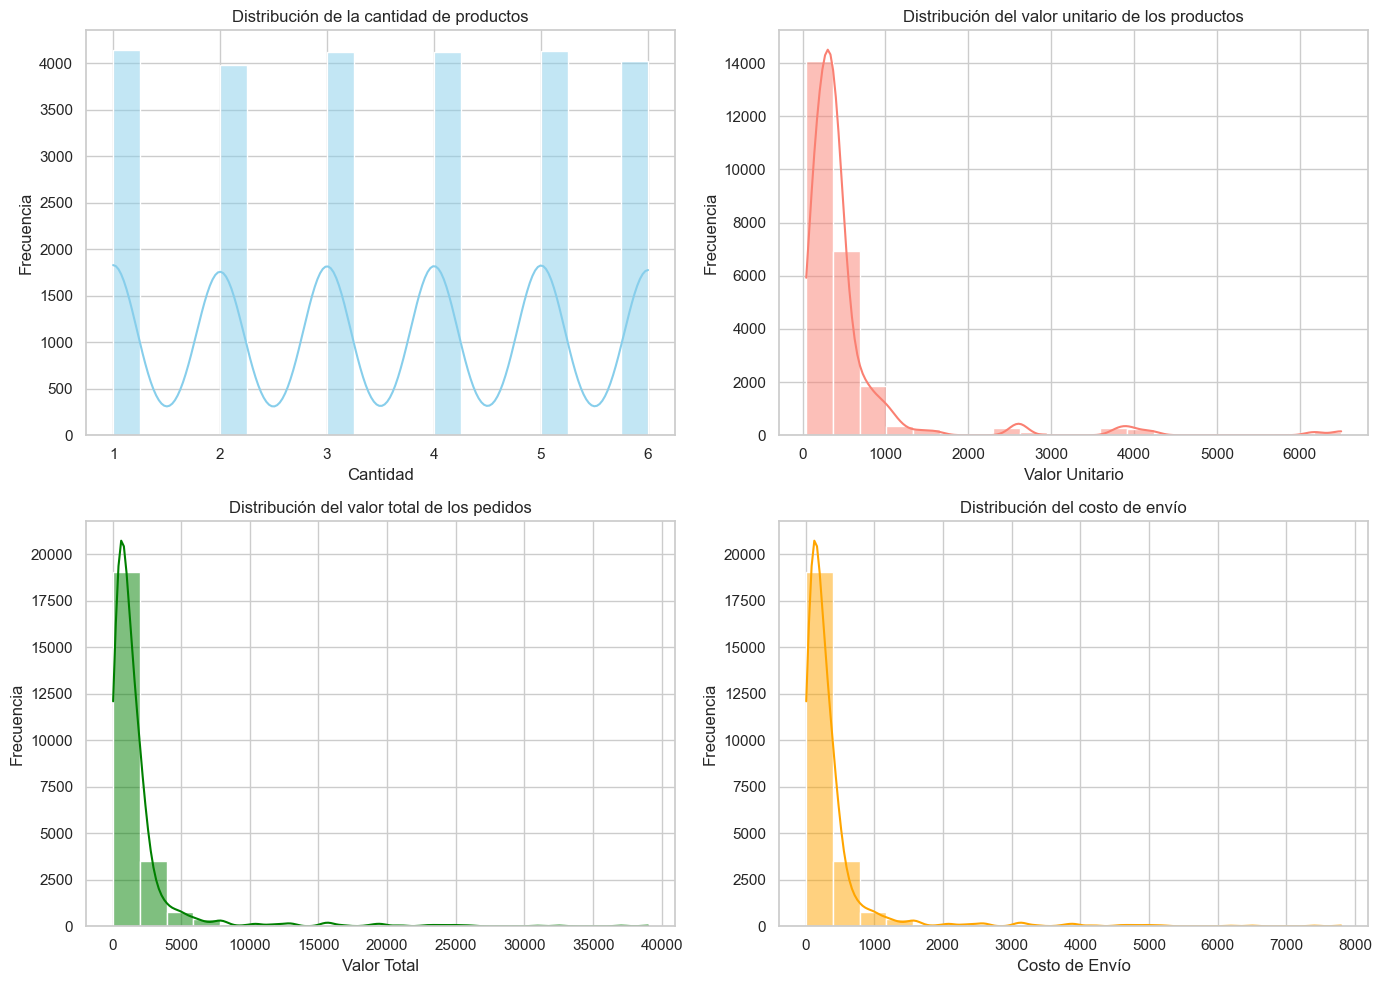

In [ ]:
# Histogramas
warnings.filterwarnings("ignore", category=FutureWarning)
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(items_pedidos_procesados['cantidad'], bins=20, kde=True, color='skyblue')
plt.title('Distribución de la cantidad de productos')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 2)
sns.histplot(items_pedidos_procesados['valor_unitario'], bins=20, kde=True, color='salmon')
plt.title('Distribución del valor unitario de los productos')
plt.xlabel('Valor Unitario')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 3)
sns.histplot(items_pedidos_procesados['valor_total'], bins=20, kde=True, color='green')
plt.title('Distribución del valor total de los pedidos')
plt.xlabel('Valor Total')
plt.ylabel('Frecuencia')

plt.subplot(2, 2, 4)
sns.histplot(items_pedidos_procesados['costo_envio'], bins=20, kde=True, color='orange')
plt.title('Distribución del costo de envío')
plt.xlabel('Costo de Envío')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


#### **Distribución de pedidos por cuidad**

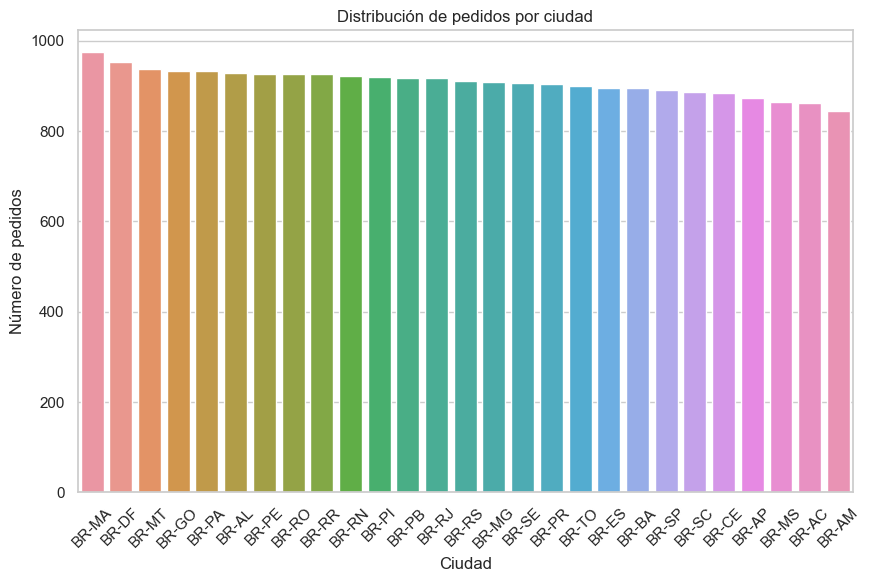

In [ ]:
# Obtener el recuento de pedidos por ciudad y ordenar de mayor a menor
ciudades_ord = items_pedidos_procesados['ciudad'].value_counts().sort_values(ascending=False)

# Configuración de estilo
sns.set(style="whitegrid")

# Crear el gráfico de barras para los pedidos
plt.figure(figsize=(10, 6))
sns.barplot(x=ciudades_ord.index, y=ciudades_ord.values, order=ciudades_ord.index)
plt.title('Distribución de pedidos por ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Número de pedidos')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para una mejor visualización
plt.show()

#### **Diagrama de dispersión (exploración)**

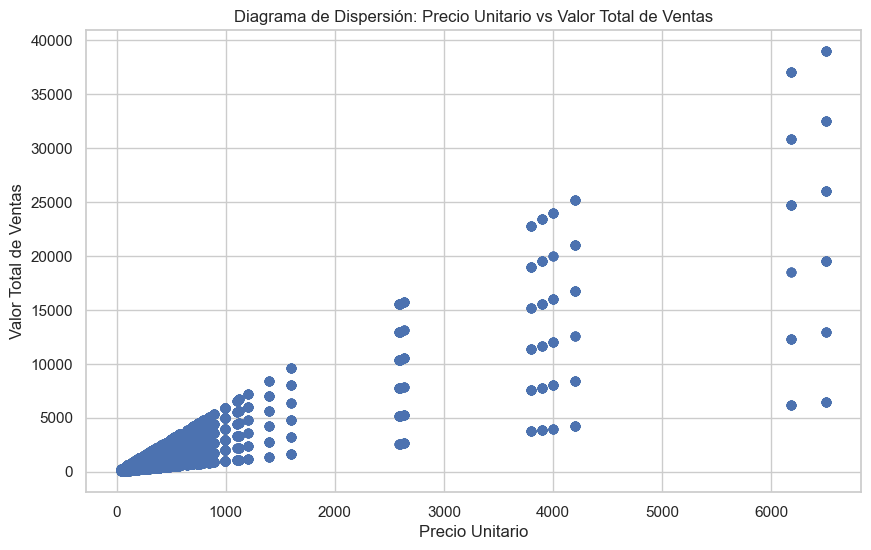

In [ ]:
# Crear el diagrama de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(items_pedidos_procesados['valor_unitario'], items_pedidos_procesados['valor_total'], alpha=0.5)
plt.title('Diagrama de Dispersión: Precio Unitario vs Valor Total de Ventas')
plt.xlabel('Precio Unitario')
plt.ylabel('Valor Total de Ventas')
plt.grid(True)
plt.show()

#### **Boxplots **

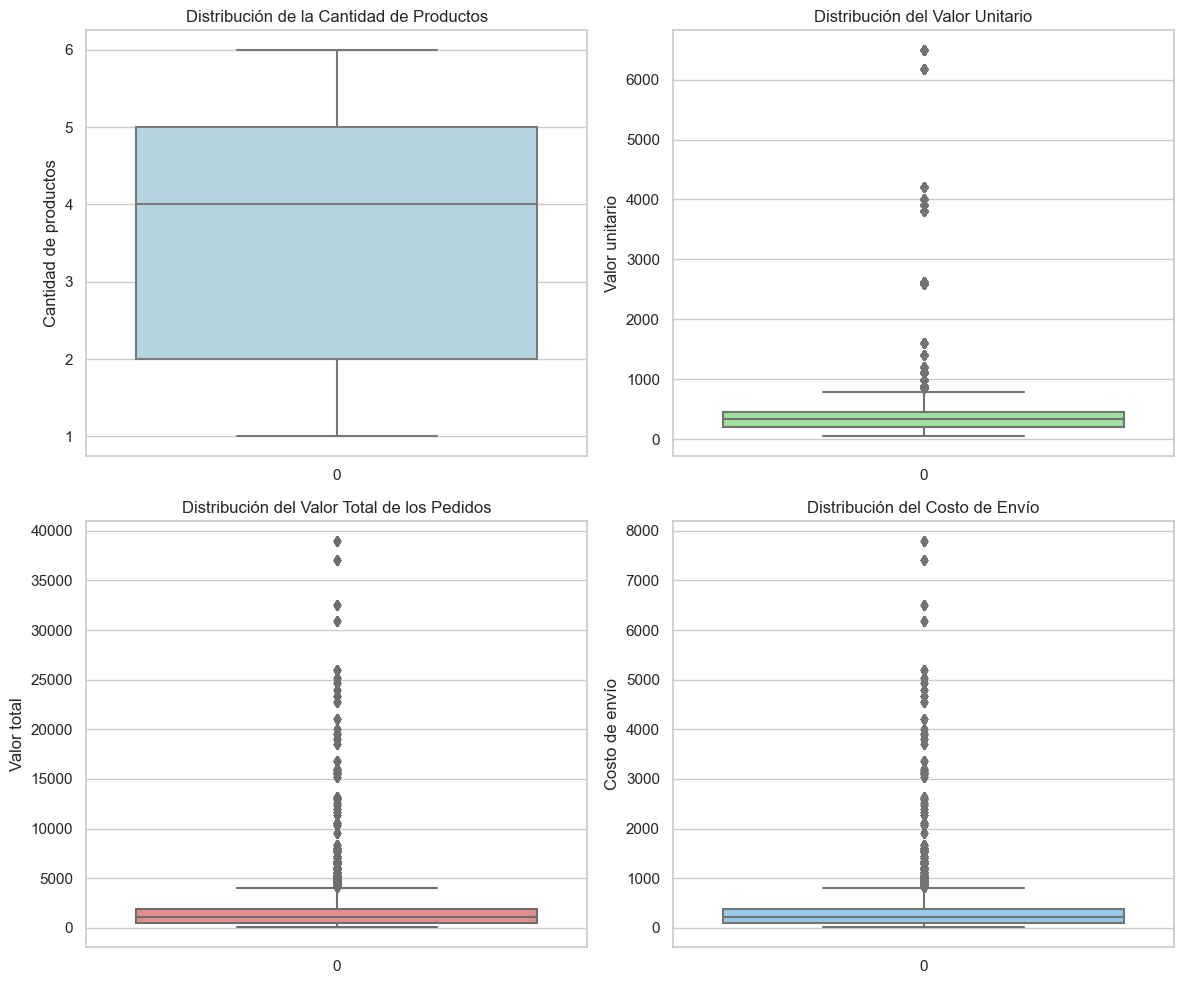

In [ ]:
# Configuración de los estilos de Seaborn
sns.set(style="whitegrid")

# Crear una figura con subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico de caja para la cantidad de productos en los pedidos
sns.boxplot(data=items_pedidos_procesados['cantidad'], color='lightblue', ax=axs[0, 0])
axs[0, 0].set_title('Distribución de la Cantidad de Productos')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Cantidad de productos')

# Gráfico de caja para el valor unitario de los productos
sns.boxplot(data=items_pedidos_procesados['valor_unitario'], color='lightgreen', ax=axs[0, 1])
axs[0, 1].set_title('Distribución del Valor Unitario')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Valor unitario')

# Gráfico de caja para el valor total de los pedidos
sns.boxplot(data=items_pedidos_procesados['valor_total'], color='lightcoral', ax=axs[1, 0])
axs[1, 0].set_title('Distribución del Valor Total de los Pedidos')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Valor total')

# Gráfico de caja para el costo de envío de los pedidos
sns.boxplot(data=items_pedidos_procesados['costo_envio'], color='lightskyblue', ax=axs[1, 1])
axs[1, 1].set_title('Distribución del Costo de Envío')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Costo de envío')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

### **2.3.2 pedidos**

In [199]:
print("Información y descripción del dataframe de pedidos:")
print(pedidos_procesados.info())
print(pedidos_procesados.describe())
print("-----------------------------------------------------------")

Información y descripción del dataframe de pedidos:
<class 'pandas.core.frame.DataFrame'>
Index: 24526 entries, 1 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int64         
 1   producto_id   24526 non-null  int64         
 2   vendedor_id   24526 non-null  int64         
 3   fecha_compra  24526 non-null  datetime64[ns]
 4   total         24526 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 1.1 MB
None
           pedido_id    producto_id   vendedor_id  \
count   24526.000000   24526.000000  24526.000000   
mean    69934.220501   44627.767961      2.975658   
min         1.000000    2706.000000      1.000000   
25%     34489.250000   17258.000000      2.000000   
50%     69946.000000   42913.000000      3.000000   
75%    105355.500000   70673.000000      4.000000   
max    139993.000000  100983.000000      5.000000   
std     4

In [200]:
pedidos_procesados.sample(5)

,pedido_id,producto_id,vendedor_id,fecha_compra,total
8725,62122,86544,4,2020-01-15,200
1015,65107,15470,4,2019-04-04,1770
8222,1689,39368,4,2020-01-03,1674
2380,103544,60010,3,2019-06-14,450
24297,42585,14074,5,2021-02-16,2250


#### **Histograma**

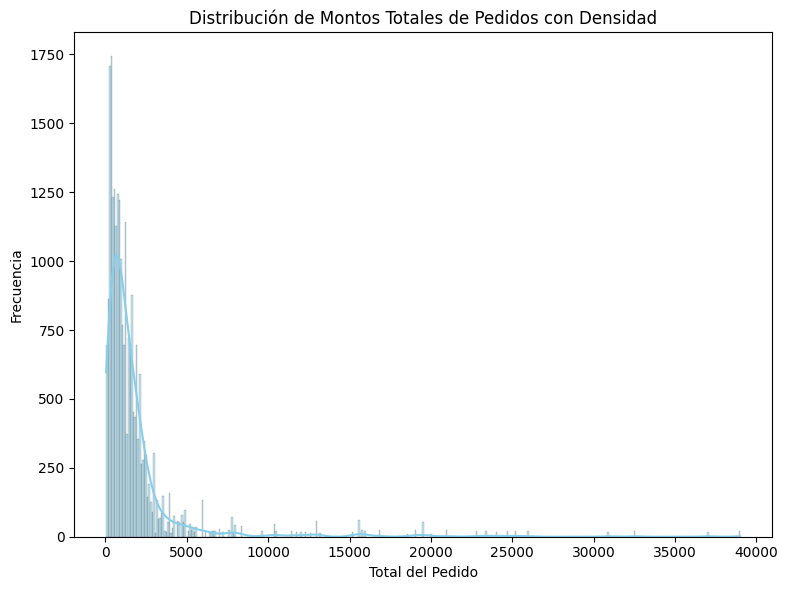

In [201]:
#Histograma de Total

plt.figure(figsize=(8, 6))
sns.histplot(pedidos_procesados['total'], kde=True, color='skyblue', edgecolor='black')
plt.title('Distribución de Montos Totales de Pedidos con Densidad')
plt.xlabel('Total del Pedido')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

#### **Pedidos por vendedor**

In [202]:
vendedores_procesados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   vendedor_id      5 non-null      int64 
 1   nombre_vendedor  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 120.0+ bytes


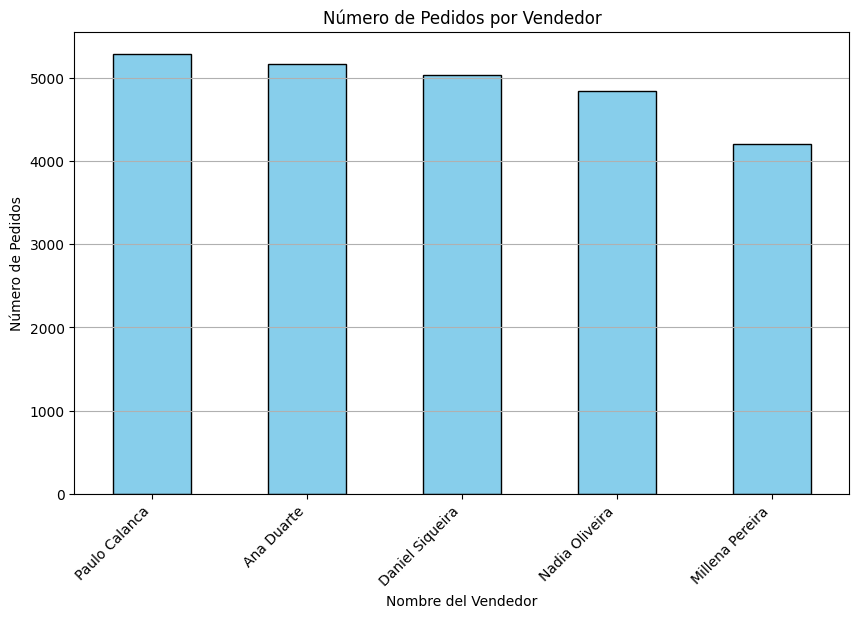

In [203]:
# Realizamos un join entre vendedor_procesado y pedidos_procesados
pedidos_vendedores = pd.merge(pedidos_procesados, vendedores_procesados, on='vendedor_id', how='left')

# Contamos el número de pedidos por vendedor
num_pedidos_por_vendedor = pedidos_vendedores['nombre_vendedor'].value_counts()

plt.figure(figsize=(10, 6))
num_pedidos_por_vendedor.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número de Pedidos por Vendedor')
plt.xlabel('Nombre del Vendedor')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

###*Vendedores EDA*
--

In [30]:
fecha_inicio = "2019-01-01"
fecha_fin = "2019-02-01"
pedidos_procesados[pedidos_procesados['fecha_compra'].between(fecha_inicio, fecha_fin)]

,pedido_id,producto_id,vendedor_id,fecha_compra,total
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
5,2980,72621,1,2019-01-05,537
...,...,...,...,...,...
149,91043,41189,2,2019-02-01,960
150,91541,61071,2,2019-02-01,2700
151,92175,17395,4,2019-02-01,2800
152,92176,17395,4,2019-02-01,2800


In [31]:
vendedores_procesados

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


In [32]:
pedidos_procesados[pedidos_procesados['fecha_compra'].between(fecha_inicio, fecha_fin)]

,pedido_id,producto_id,vendedor_id,fecha_compra,total
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
5,2980,72621,1,2019-01-05,537
...,...,...,...,...,...
149,91043,41189,2,2019-02-01,960
150,91541,61071,2,2019-02-01,2700
151,92175,17395,4,2019-02-01,2800
152,92176,17395,4,2019-02-01,2800


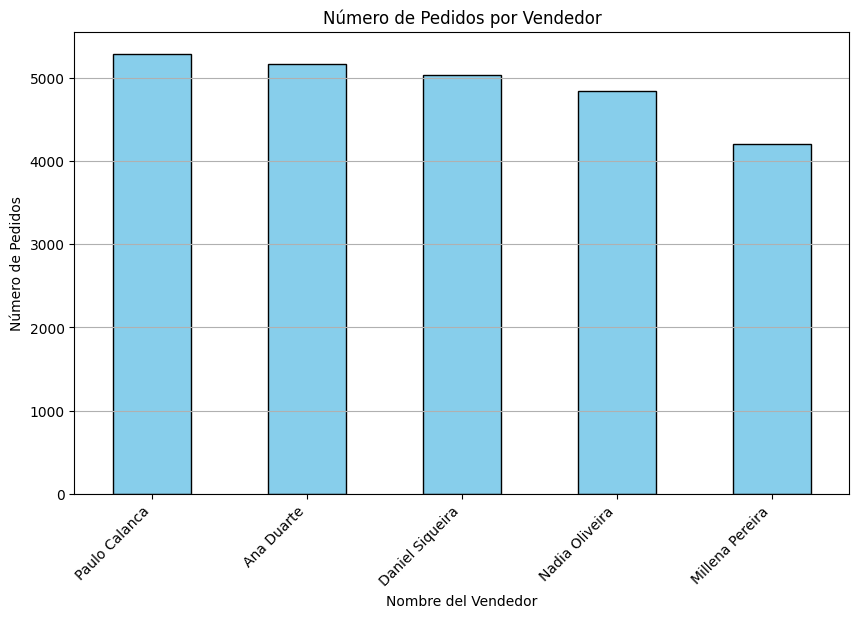

In [33]:
# Realizamos un join entre vendedor_procesado y pedidos_procesados
pedidos_vendedores = pd.merge(pedidos_procesados, vendedores_procesados, on='vendedor_id', how='left')

# Contamos el número de pedidos por vendedor
num_pedidos_por_vendedor = pedidos_vendedores['nombre_vendedor'].value_counts()

plt.figure(figsize=(10, 6))
num_pedidos_por_vendedor.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número de Pedidos por Vendedor')
plt.xlabel('Nombre del Vendedor')
plt.ylabel('Número de Pedidos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

#### **Disperción fecha vs Total (exploración)**

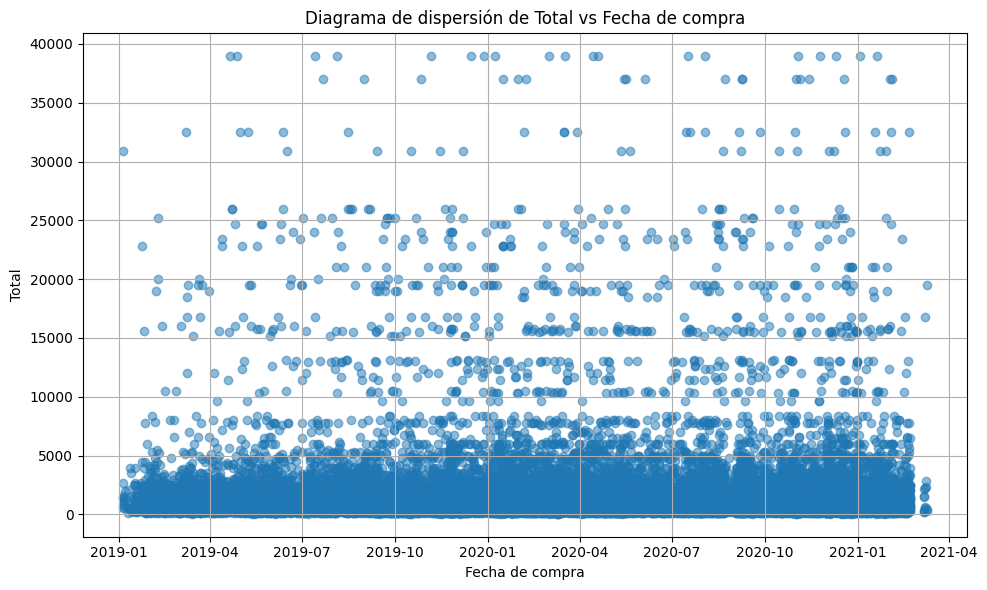

In [34]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(pedidos_procesados['fecha_compra'], pedidos_procesados['total'], alpha=0.5)

# Añadir etiquetas y título
plt.title('Diagrama de dispersión de Total vs Fecha de compra')
plt.xlabel('Fecha de compra')
plt.ylabel('Total')

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Ventas por año y mes (Group by Mount and Year)**

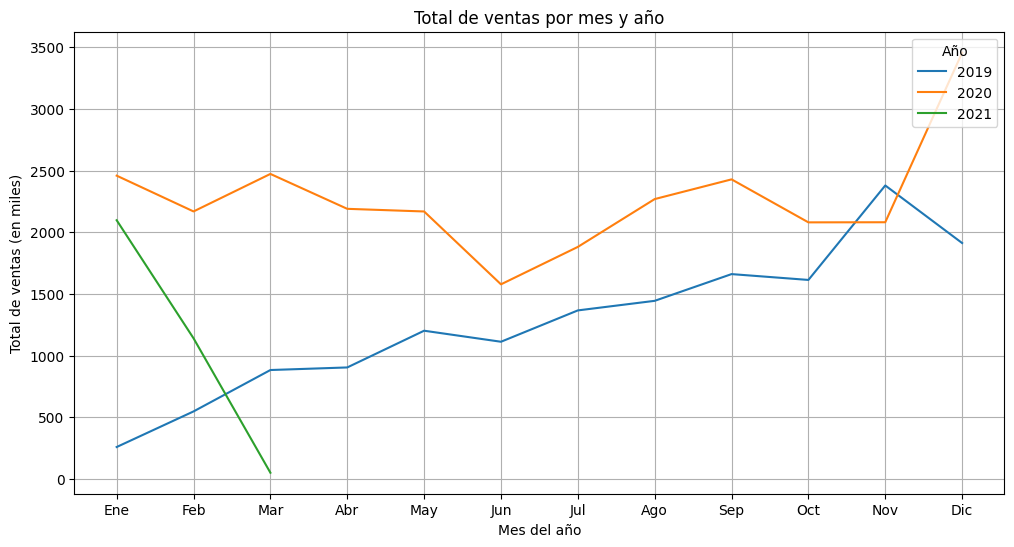

In [35]:
# Crear una nueva columna 'año' que represente el año en el que se realizó la compra
pedidos_procesados['año'] = pedidos_procesados['fecha_compra'].dt.year

# Crear una nueva columna 'mes' que represente el mes en el que se realizó la compra
pedidos_procesados['mes'] = pedidos_procesados['fecha_compra'].dt.month

# Agrupar los datos por año y mes y calcular el total de ventas para cada combinación
ventas_por_año_mes = pedidos_procesados.groupby(['año', 'mes'])['total'].sum().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
for año in ventas_por_año_mes['año'].unique():
    datos_año = ventas_por_año_mes[ventas_por_año_mes['año'] == año]
    plt.plot(datos_año['mes'], datos_año['total'] / 1000, label=str(año))

plt.xlabel('Mes del año')
plt.ylabel('Total de ventas (en miles)')
plt.title('Total de ventas por mes y año')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend(title='Año', loc='upper right')
plt.grid(True)
plt.show()

#### **Boxplot**

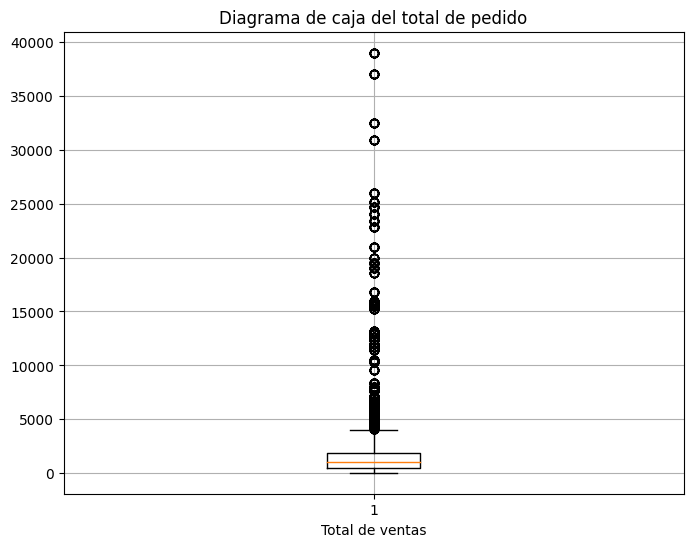

In [36]:
# Crear el diagrama de caja
plt.figure(figsize=(8, 6))
plt.boxplot(pedidos_procesados['total'])

plt.xlabel('Total de ventas')
plt.title('Diagrama de caja del total de pedido')
plt.grid(True)
plt.show()

### **2.3.3 Productos**

In [208]:

print("Información y descripción del dataframe de productos:")
print(productos_procesados.info())
print(productos_procesados.describe())
print("-----------------------------------------------------------")

Información y descripción del dataframe de productos:
<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   producto_id  205 non-null    int64  
 1   producto     205 non-null    object 
 2   precio       205 non-null    int64  
 3   marca        205 non-null    object 
 4   sku          205 non-null    float64
 5   condicion    205 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 11.2+ KB
None
         producto_id       precio            sku
count     205.000000   205.000000     205.000000
mean    44803.365854   536.009756  304625.234146
std     29419.632374   843.774387  190141.444036
min      2706.000000    45.000000  101494.000000
25%     17329.000000   210.000000  222028.000000
50%     43054.000000   336.000000  263899.000000
75%     70673.000000   450.000000  304828.000000
max    100983.000000  6500.000000  952821.000000
--

In [209]:
print("Cantidad de productos unicos: ", productos_procesados['producto'].value_counts())

Cantidad de productos unicos:  producto
Calca Alfaiataria Preta    2
Saia Pregas Preta          2
Vestido Recortes Cores     2
Calca Jeans Costuras       2
Oculos Lente Azulada       1
                          ..
Shorts Listras Bordados    1
Saia Lurex Color           1
Body Estampa Coracoes      1
Peeptoe Preto Verniz       1
Calca Jeans Basica         1
Name: count, Length: 201, dtype: int64


In [210]:
print("Cantidad de productos unicos: ", productos_procesados['marca'].value_counts())

Cantidad de productos unicos:  marca
Zara               23
Mixed              14
Animale             9
Le Lis Blanc        6
Banana Republic     5
                   ..
Thay Ribas          1
Carter’s            1
American Eagle      1
Isolda              1
Express             1
Name: count, Length: 117, dtype: int64


In [211]:
print("Cantidad de productos unicos: ", productos_procesados['condicion'].value_counts())

Cantidad de productos unicos:  condicion
Usado                 176
Nuevo con etiqueta     22
Nuevo sin etiqueta      7
Name: count, dtype: int64


#### **Productos por condición**

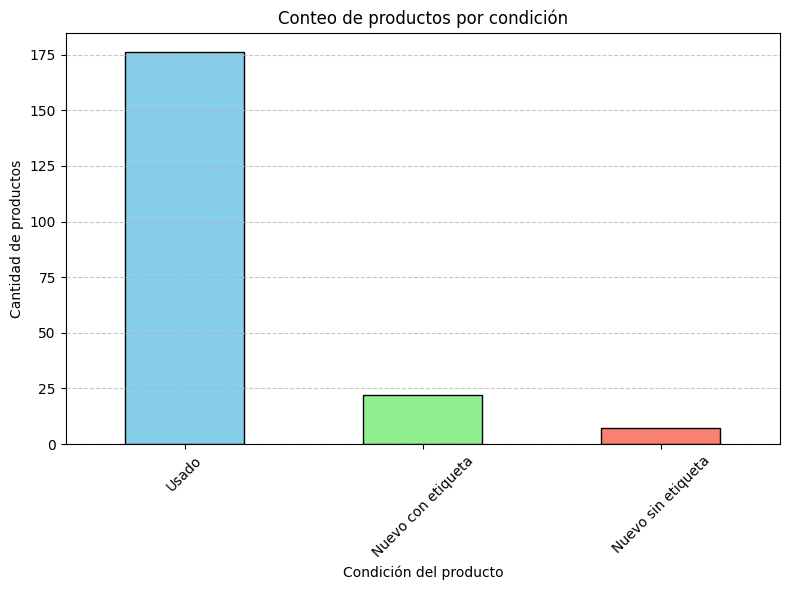

In [212]:
colors = ['skyblue', 'lightgreen', 'salmon']

# Crear un gráfico de barras para visualizar el conteo de productos por condición
plt.figure(figsize=(8, 6))
productos_procesados['condicion'].value_counts().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Conteo de productos por condición')
plt.xlabel('Condición del producto')
plt.ylabel('Cantidad de productos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### **Boxplot de precios por condición**

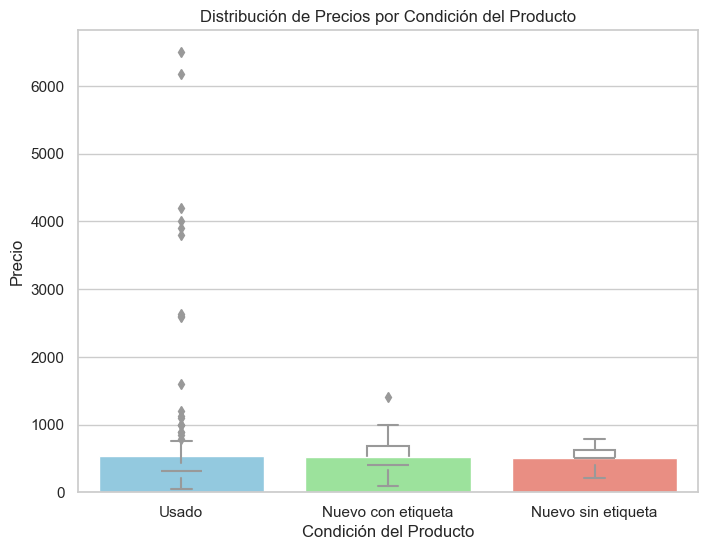

In [ ]:
# Extraer los valores únicos de la columna 'condicion'
condiciones_unicas = productos_procesados['condicion'].unique()
colores_condicion = {condicion: color for condicion, color in zip(condiciones_unicas, ['skyblue', 'lightgreen', 'salmon'])}

# Crear el gráfico combinado de barras y diagrama de caja
plt.figure(figsize=(8, 6))
sns.barplot(x='condicion', y='precio', data=productos_procesados, palette=colores_condicion, ci=None)
sns.boxplot(x='condicion', y='precio', data=productos_procesados, color='white', width=0.2)

plt.title('Distribución de Precios por Condición del Producto')
plt.xlabel('Condición del Producto')
plt.ylabel('Precio')

# Mostrar el gráfico
plt.show()

#### **Precios por Condición del Producto**

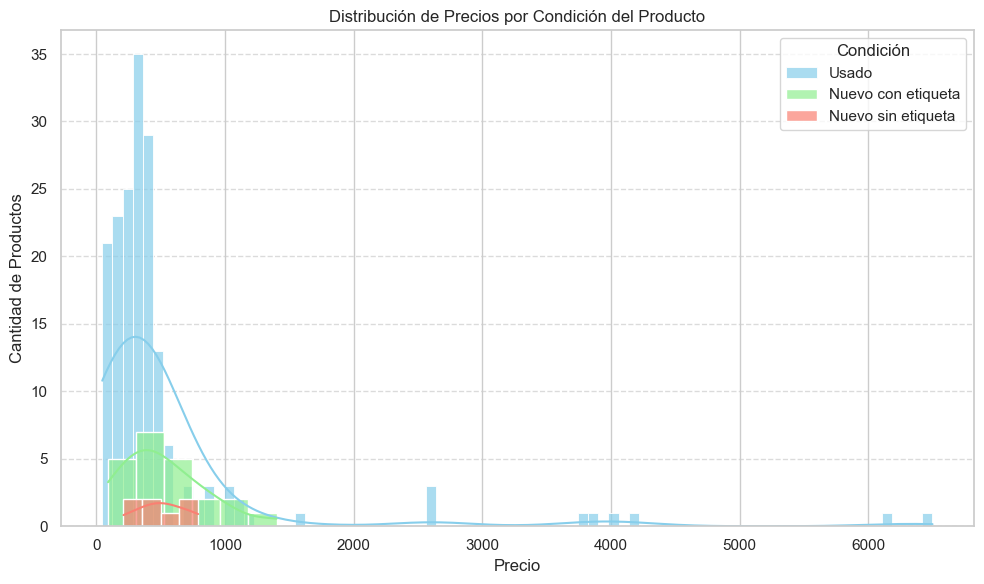

In [ ]:
# Extraer los valores únicos de la columna de condición y eliminar espacios adicionales
condiciones_unicas = productos_procesados['condicion'].str.strip().unique()

# Crear un diccionario para mapear cada condición a un color
colores_condicion = {condicion: color for condicion, color in zip(condiciones_unicas, ['skyblue', 'lightgreen', 'salmon'])}

# Crear un gráfico de histograma para visualizar la distribución de precios por condición
plt.figure(figsize=(10, 6))
for condicion in condiciones_unicas:
    sns.histplot(data=productos_procesados[productos_procesados['condicion'].str.strip() == condicion],
                 x='precio', color=colores_condicion[condicion], label=condicion, kde=True, alpha=0.7)
plt.title('Distribución de Precios por Condición del Producto')
plt.xlabel('Precio')
plt.ylabel('Cantidad de Productos')
plt.legend(title='Condición')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **3 Banco de Datos**


---

###Renombrar dataframes

In [31]:
# Asignar los contenidos de los dataframes procesados a los dataframes originales
df_items_pedidos = items_pedidos_procesados.copy()
df_pedidos = pedidos_procesados.copy()
df_productos = productos_procesados.copy()
df_vendedores = vendedores_procesados.copy()

In [32]:
print("items pedidos ")
print(df_items_pedidos.info())
print("pedidos")
print(df_pedidos.info())
print("productos")
print(df_productos.info())
print("vendedores")
print(df_vendedores.info())

items pedidos 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
pedidos
<class 'pandas.core.frame.DataFrame'>
Index: 24526 entries, 1 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24526 non-null  int64         
 1   producto_id   24526 non-null  int64         
 2   vendedor_id   24526 non-null  int64         

## **3.1 Crear base de datos y motor**

####Función para CREAR base de datos

In [33]:
def crear_base_datos(dataframes, db_name, db_path):
    global df_items_pedidos, df_pedidos, df_productos, df_vendedores

    """
    Crea una base de datos y agrega los DataFrames como tablas.

    Args:
    - dataframes: Un diccionario donde las claves son los nombres de las tablas y los valores son los DataFrames.
    - db_name: El nombre de la base de datos a crear.
    - db_path: La ruta para guardar la base de datos.

    Returns:
    - None
    """
    # Crear engine
    engine = create_engine('sqlite:///' + db_path + db_name, echo=False)

    # Guardar DataFrames en la base de datos como tablas
    for table_name, df in dataframes.items():
        df.to_sql(table_name, con=engine, if_exists='replace', index=False)

    # Cerrar la conexión
    engine.dispose()

    print(f"Base de datos '{db_name}' creada y tablas agregadas.")

# # Ejemplo de uso
# dataframes = {
#     'items_pedidos': df_items_pedidos,
#     'pedidos': df_pedidos,
#     'productos': df_productos,
#     'vendedores': df_vendedores
# }
# db_name='database.db'
# db_path='/content/drive/MyDrive/Notebooks/Proyecto/'
# # Crear la base de datos y agregar los DataFrames
# crear_base_datos(dataframes,db_name=db_name,db_path=db_path)


####Crear Base de datos y tablas asociadas

In [34]:
dataframes = {
    'items_pedidos': df_items_pedidos,
    'pedidos': df_pedidos,
    'productos': df_productos,
    'vendedores': df_vendedores
}

db_name='database.db'
db_path='/content/drive/MyDrive/Colab Notebooks/Proyecto Store Sales Analysis/'

crear_base_datos(dataframes,db_name,db_path=db_path)

Base de datos 'database.db' creada y tablas agregadas.


## **3.2 Conectar con base de datos**

####Función para CONECTAR con base de datos

In [3]:
def crear_conexion(db_name, db_path):
    global df_items_pedidos, df_pedidos, df_productos, df_vendedores, engine
    # Crear la conexión a la base de datos
    engine = create_engine('sqlite:///' + db_path + db_name, echo=False)
    database = engine.connect()
    return database

####Crear CONEXIÓN con base de datos y acceder a consultas

In [4]:
# Llamar a la función para crear la conexión
db_name='database.db'
db_path='/content/drive/MyDrive/Colab Notebooks/Proyecto Store Sales Analysis/'

database = crear_conexion(db_name=db_name, db_path=db_path)

# Ahora puedes acceder a la variable "database"
# Usar el inspector para obtener información sobre las tablas y columnas
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column)

# # Cerrar la conexión
# database.close()

Tablas:  ['items_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'vendedor_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'fecha_compra', 'type': DATETIME(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'total', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}


####Realizando una consulta

In [6]:
# Definir otra consulta SQL
query = """SELECT * FROM vendedores WHERE vendedor_id=5 """

# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
df_ejemplo = pd.read_sql(sql=text(query), con=database)
df_ejemplo
# Cerrar la conexión
# database.close()

,vendedor_id,nombre_vendedor
0,5,Paulo Calanca


In [92]:
df_ejemplo

,vendedor_id,nombre_vendedor
0,5,Paulo Calanca


##**Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

In [16]:
# Definir la consulta SQL
consulta_sql = text("""
SELECT
    p.fecha_compra AS "Fecha",
    (p.total - i.costo_envio) AS "Ingreso neto",
    pr.marca AS "Marca de producto"
FROM
    pedidos p
INNER JOIN
    items_pedidos i ON p.pedido_id = i.pedido_id
INNER JOIN
    productos pr ON i.producto_id = pr.producto_id
ORDER BY
    p.fecha_compra;

""")

# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
resultados = database.execute(consulta_sql)

# Guardar los resultados en un DataFrame
df_ingresos= pd.DataFrame(resultados)
df_ingresos

,Fecha,Ingreso neto,Marca de producto
0,2019-01-05 00:00:00.000000,24700.0,Bottega Veneta
1,2019-01-05 00:00:00.000000,480.0,Topshop
2,2019-01-05 00:00:00.000000,667.2,Lezalez
3,2019-01-05 00:00:00.000000,1260.0,Tigresse
4,2019-01-05 00:00:00.000000,429.6,Zara
...,...,...,...
24521,2021-03-09 00:00:00.000000,1888.0,J. Crew
24522,2021-03-09 00:00:00.000000,2240.0,Animale
24523,2021-03-10 00:00:00.000000,15600.0,Christian Louboutin
24524,2021-03-10 00:00:00.000000,333.6,Lezalez


In [17]:
df_ingresos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24526 entries, 0 to 24525
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Fecha              24526 non-null  object 
 1   Ingreso neto       24526 non-null  float64
 2   Marca de producto  24526 non-null  object 
dtypes: float64(1), object(2)
memory usage: 575.0+ KB


###Preparación de dataframe para graficar histórico de ingresos netos

In [ ]:
# Convertir la columna 'fecha_compra' a tipo de datos datetime
df_ingresos['Fecha'] = pd.to_datetime(df_ingresos['Fecha'])

# Formatear la columna 'fecha_compra' en el formato deseado
df_ingresos['Fecha'] = df_ingresos['Fecha'].dt.strftime('%Y-%m-%d')

# Convertir la columna 'fecha_compra' a tipo de datos datetime
df_ingresos['Fecha'] = pd.to_datetime(df_ingresos['Fecha'])

#Crear nueva columna formateada a miles en el ingreso neto
df_ingresos['Ingreso_neto(K)']=(df_ingresos["Ingreso neto"]/1000).round(4).apply(lambda x: f'${x:.4f}K')

####Buscardor de fecha

In [37]:
buscador_fecha=df_ingresos[df_ingresos['Fecha']=="2019-11-24"]

In [38]:
buscador_fecha

,Fecha,Ingreso neto,Marca de producto,Ingreso_neto(K)
6540,2019-11-24,1680.0,Luisa Farani,$1.6800K
6541,2019-11-24,792.0,Diesel,$0.7920K
6542,2019-11-24,1248.0,Animale,$1.2480K
6543,2019-11-24,768.0,Zara,$0.7680K
6544,2019-11-24,384.0,Le Lis Blanc,$0.3840K
...,...,...,...,...
6747,2019-11-24,384.0,Farm,$0.3840K
6748,2019-11-24,1760.0,Ellus,$1.7600K
6749,2019-11-24,1560.0,Banana Republic,$1.5600K
6750,2019-11-24,624.0,All Saints Spitalfields,$0.6240K


####Visualización Evolución Histórica de ingresos

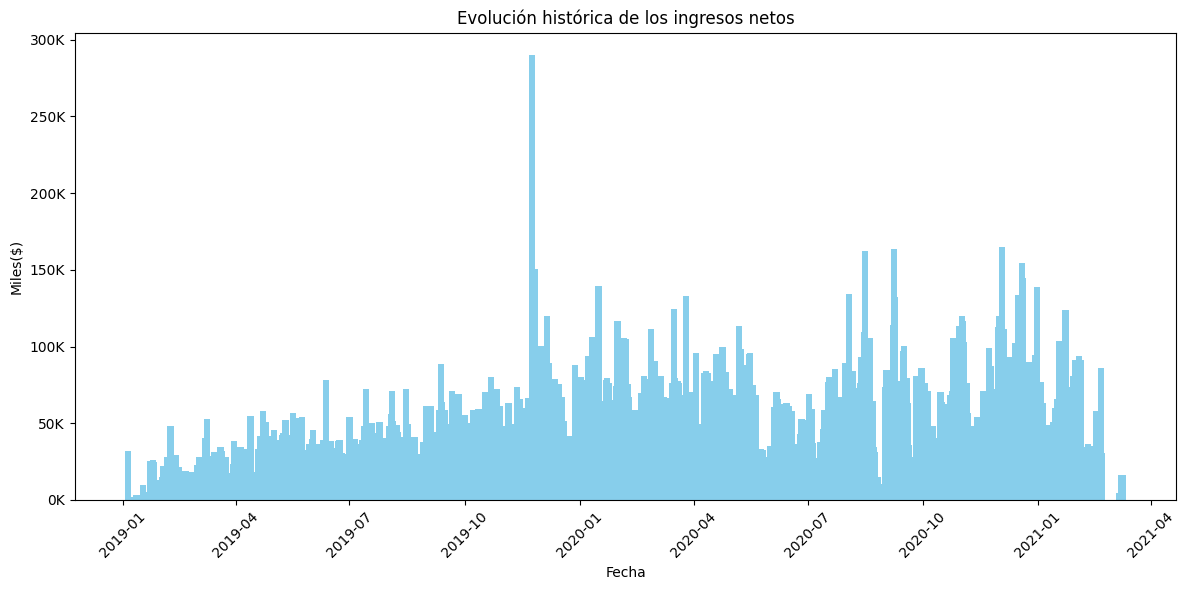

In [46]:
# Agregar una columna para los ingresos netos transformados
df_ingresos['Ingreso_neto(K)'] = (df_ingresos['Ingreso neto'] / 1000).round(4).apply(lambda x: f'${x:.4f}K')

# Agrupar los datos por día y sumar los ingresos netos
ingresos_por_dia = df_ingresos.groupby('Fecha')['Ingreso neto'].sum()

# Configurar el gráfico
plt.figure(figsize=(12, 6))  # Ajustar el tamaño del gráfico
plt.bar(ingresos_por_dia.index, ingresos_por_dia.values, color='skyblue', width=5)  # Ajustar el ancho de las barras

# Configurar los ejes y el título
plt.title('Evolución histórica de los ingresos netos')
plt.xlabel('Fecha')
plt.ylabel('Miles($)')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para mejor legibilidad

# Formatear los valores de los ingresos netos en la escala de miles(K)
formatter = plt.FuncFormatter(lambda x, _: '{:,.0f}K'.format(x/1000))
plt.gca().yaxis.set_major_formatter(formatter)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



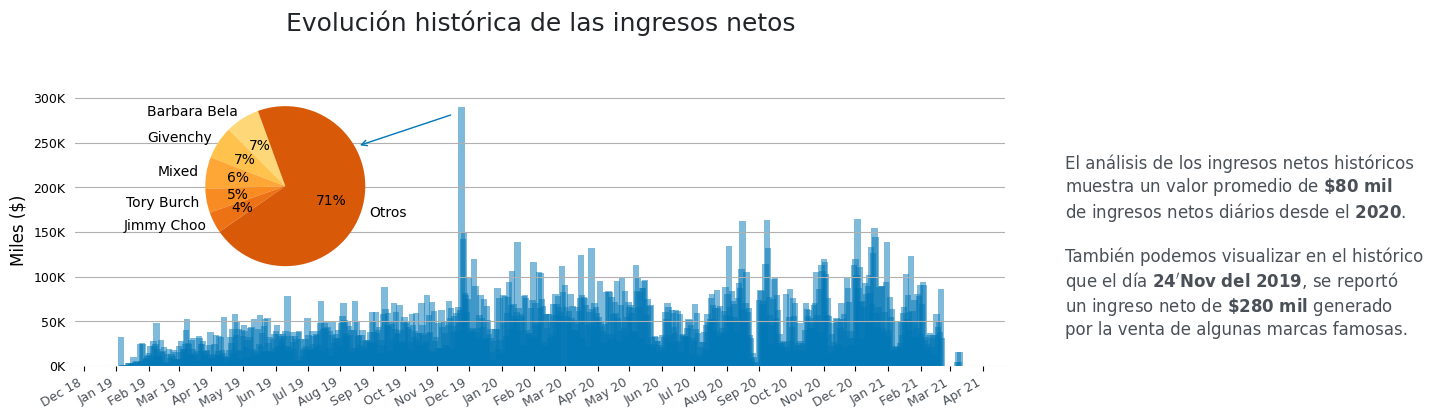

# **4 ¿Cual es el Top 5 productos más vendidos históricamente?**


---

In [54]:
# Definir la consulta SQL
consulta_sql = text("""
    SELECT p.producto_id, p.producto, p.marca,
           SUM(i.cantidad) AS cantidad_vendida,
           SUM(i.cantidad * pr.precio) AS monto_total
    FROM productos p
    INNER JOIN items_pedidos i ON p.producto_id = i.producto_id
    INNER JOIN productos pr ON p.producto_id = pr.producto_id
    GROUP BY p.producto_id, p.producto, p.marca
    ORDER BY cantidad_vendida DESC
    LIMIT 5
""")

# Ejecutar la consulta SQL y cargar los resultados en un DataFrame
resultados = database.execute(consulta_sql)

# Guardar los resultados en un DataFrame
df = pd.DataFrame(resultados, columns=['producto_id', 'producto', 'marca', 'cantidad_vendida', 'monto_total'])


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   producto_id       5 non-null      int64 
 1   producto          5 non-null      object
 2   marca             5 non-null      object
 3   cantidad_vendida  5 non-null      int64 
 4   monto_total       5 non-null      int64 
dtypes: int64(3), object(2)
memory usage: 328.0+ bytes
